# Environments


### Overview

We provide **Environments** that follow the [OpenAI gym](https://github.com/openai/gym) interface for applications such as reinforcement learning algorithms. Generally speaking, an **Environment** instantiates **Scene**, **Object** and **Robot** and import them into its **Simulator**. An **Environment** also instantiates a list of **Sensors** (usually as part of the observation space) and a **Task**, which further includes a list of **Reward Functions** and **Termination Conditions**.

Most of the code can be found here: [gibson2/envs/igibson_env.py](https://github.com/StanfordVL/iGibson/blob/master/gibson2/envs/igibson_env.py).


#### Sensors

We provide different types of sensors as lightweight wrappers around the renderer. Currently we support RGB, surface normal, segmentation, 3D point cloud, depth map, optical flow, and scene flow, and also 1-beam and 16-beam LiDAR signals. Additionally, we provide a sensor noise model with random dropout (currently only for depth map and 1-beam LiDAR) to simulate real-world sensor noise. The amount of noise can be controlled by `depth_noise_rate` and `scan_noise_rate` in the config files. Contribution of more noise models is most welcome.

Most of the code can be found in [gibson2/sensors](https://github.com/StanfordVL/iGibson/tree/master/gibson2/sensors).


#### Tasks

Each **Task** should implement `reset_scene`, `reset_agent`, `step` and `get_task_obs`.
- `reset_scene` and `reset_agent` will be called during `env.reset` and should include task-specific details to reset the scene and the agent, respectively.
- `step` will be called during `env.step` and should include task-specific details of what needs to be done at every timestep. 
- `get_task_obs` returns task-specific observation (non-sensory observation) as a numpy array. For instance, typical goal-oriented robotics tasks should include goal information and proprioceptive states in `get_task_obs`.
Each **Task** should also include a list of **Reward Functions** and **Termination Conditions** defined below.
We provide a few Embodied AI tasks.
- PointGoalFixedTask
- PointGoalRandomTask
- InteractiveNavRandomTask
- DynamicNavRandomTask
- ReachingRandomTask
- RoomRearrangementTask

Most of the code can be found in [gibson2/tasks](https://github.com/StanfordVL/iGibson/tree/master/gibson2/tasks).


#### Reward Functions

At each timestep, `env.step` will call `task.get_reward`, which in turn sums up all the reward terms. 
We provide a few common reward functions for robotics tasks.
- PointGoalReward
- ReachingGoalReward
- PotentialReward
- CollisionReward

Most of the code can be found in [gibson2/reward_functions](https://github.com/StanfordVL/iGibson/tree/master/gibson2/reward_functions).

#### Termination Conditions

At each timestep, `env.step` will call `task.get_termination`, which in turn checks each of the termination condition to see if the episode is done and/or successful. 
We provide a few common termination conditions for robotics tasks.
- PointGoal
- ReachingGoal
- MaxCollision
- Timeout
- OutOfBound
Most of the code can be found in [gibson2/termination_conditions](https://github.com/StanfordVL/iGibson/tree/master/gibson2/termination_conditions).

#### Configs
To instantiate an **Environment**, we first need to create a YAML config file. It will specify parameters for the **Environment** (e.g. robot type, action frequency, etc), the **Sensors** (e.g. sensor types, image resolution, noise rate, etc), the **Task** (e.g. task type, goal distance range, etc), the **Reward Functions** (e.g. reward types, reward scale, etc) and the **Termination Conditions** (e.g. goal convergence threshold, time limit, etc). Exapmles of config files can be found here: [examples/configs](https://github.com/StanfordVL/iGibson/tree/master/examples/configs).

Here is one example: [examples/configs/turtlebot_point_nav.yaml](https://github.com/StanfordVL/iGibson/blob/master/examples/configs/turtlebot_point_nav.yaml)

```yaml
# scene
scene: igibson
scene_id: Rs_int
build_graph: true
load_texture: true
pybullet_load_texture: true
trav_map_type: no_obj
trav_map_resolution: 0.1
trav_map_erosion: 2
should_open_all_doors: true

# domain randomization
texture_randomization_freq: null
object_randomization_freq: null

# robot
robot: Turtlebot
is_discrete: false
velocity: 1.0

# task
task: point_nav_random
target_dist_min: 1.0
target_dist_max: 10.0
goal_format: polar
task_obs_dim: 4

# reward
reward_type: geodesic
success_reward: 10.0
potential_reward_weight: 1.0
collision_reward_weight: -0.1

# discount factor
discount_factor: 0.99

# termination condition
dist_tol: 0.36  # body width
max_step: 500
max_collisions_allowed: 500

# misc config
initial_pos_z_offset: 0.1
collision_ignore_link_a_ids: [1, 2, 3, 4]  # ignore collisions with these robot links

# sensor spec
output: [task_obs, rgb, depth, scan]
# image
# ASUS Xtion PRO LIVE
# https://www.asus.com/us/3D-Sensor/Xtion_PRO_LIVE
fisheye: false
image_width: 160
image_height: 120
vertical_fov: 45
# depth
depth_low: 0.8
depth_high: 3.5
# scan
# Hokuyo URG-04LX-UG01
# https://www.hokuyo-aut.jp/search/single.php?serial=166
# n_horizontal_rays is originally 683, sub-sampled 1/3
n_horizontal_rays: 228
n_vertical_beams: 1
laser_linear_range: 5.6
laser_angular_range: 240.0
min_laser_dist: 0.05
laser_link_name: scan_link

# sensor noise
depth_noise_rate: 0.0
scan_noise_rate: 0.0

# visual objects
visual_object_at_initial_target_pos: true
target_visual_object_visible_to_agent: false
```


Parameters of this config file are explained below:

| Attribute | Example Value | Expalanation |
| ----------| ------------- | ------------ |
| scene | igibson | which type of scene: [empty, stadium, gibson, igibson] |
| scene_id | Rs_int | scene_id for the gibson or igibson scene |
| build_graph | true | whether to build traversability graph for the building scene |
| load_texture | true | whether to load texture into MeshRenderer. Can be set to false if RGB is not needed |
| pybullet_load_texture | true | whether to load texture into PyBullet, for debugging purpose only |
| trav_map_resolution | 0.1 | resolution of the traversability map. 0.1 means each pixel represents 0.1 meter |
| trav_map_erosion | 2 | number of pixels to erode the traversability map. trav_map_resolution * trav_map_erosion should be almost equal to the radius of the robot base |
| should_open_all_doors | True | whether to open all doors in the scene during episode reset (e.g. useful for cross-room navigation tasks) |
| texture_randomization_freq | null | whether to perform material/texture randomization (null means no randomization, 10 means randomize every 10 episodes) |
| object_randomization_freq | null | whether to perform object randomization (null means no randomization, 10 means randomize every 10 episodes) |
| robot | Turtlebot | which type of robot, e.g. Turtlebot, Fetch, Locobot, etc |
| is_discrete | false | whether to use discrete action space for the robot |
| velocity | 1.0 | maximum normalized joint velocity. 0.5 means maximum robot action will actuate half of maximum joint velocities that are allowed in the robot URDF file |
| task | point_nav_random | which type of task, e.g. point_nav_random, room_rearrangement, etc |
| target_dist_min | 1.0 | minimum distance (in meters) between the initial and target positions for the navigation task |
| target_dist_max | 10.0 | maximum distance (in meters) between the initial and target positions for the navigation task |
| goal_format | polar | which format to represent the navigation goals: [polar, cartesian] |
| task_obs_dim | 4 | the dimension of task-specific observation returned by task.get_task_obs |
| reward_type | geodesic | which type of reward: [geodesic, l2, sparse], or define your own |
| success_reward | 10.0 | scaling factor of the success reward |
| slack_reward | -0.01 | scaling factor of the slack reward (negative because it should be a penalty) |
| potential_reward_weight | 1.0 | scaling factor of the potential reward |
| collision_reward_weight | -0.1 | scaling factor of the collision reward (negative because it should be a penalty) |
| discount_factor | 0.99 | discount factor for the MDP |
| dist_tol | 0.36 | the distance tolerance for converging to the navigation goal. This is usually equal to the diameter of the robot base |
| max_step | 500 | maximum number of timesteps allowed in an episode |
| max_collisions_allowed | 500 | maximum number of timesteps with robot collision allowed in an episode |
| initial_pos_z_offset | 0.1 | z-offset (in meters) when placing the robots and the objects to accommodate uneven floor surface |
| collision_ignore_link_a_ids | [1, 2, 3, 4] | collision with these robot links will not result in collision penalty. These usually are links of wheels 
| output | [task_obs, rgb, depth, scan] | what observation space is. sensor means task-specific, non-sensory information (e.g. goal info, proprioceptive state), rgb and depth mean RGBD camera sensing, scan means LiDAR sensing |
| fisheye | false | whether to use fisheye camera |
| image_width | 640 | image width for the camera |
| image_height | 480 | image height for the camera |
| vertical_fov | 45 | camera vertial field of view (in degrees) |
| depth_low | 0.8 | lower bound of the valid range of the depth camera |
| depth_high | 3.5 | upper bound of the valid range of the depth camera |
| n_horizontal_rays | 228 | number of horizontal rays to simulate for the LiDAR |
| n_vertical_beams | 1 | number of vertical beams to simulate for the LiDAR. Currently iGibson only supports n_vertical_beams == 1 |
| laser_linear_range | 5.6 | upper bound of the valid range of the LiDAR |
| laser_angular_range | 240.0 | angular range of the LiDAR (in degrees) |
| min_laser_dist | 0.05 | lower bound of the valid range of the LiDAR |
| laser_link_name | scan_link | the link name of the LiDAR sensor in the robot URDF file |
| depth_noise_rate | 0.0 | noise rate for the depth camera. 0.1 means 10% of the pixels will be corrupted (set to 0.0) |
| scan_noise_rate | 0.0 | noise rate for the LiDAR. 0.1 means 10% of the rays will be corrupted (set to laser_linear_range) |
| visual_object_at_initial_target_pos | true | whether to show visual markers for the initial and target positions |
| target_visual_object_visible_to_agent | false | whether these visual markers are visible to the agents |



### Examples

#### Static Environments
In this example, we show how to instantiate `iGibsonEnv` and how to step through the environment. At the beginning of each episode, we need to call `env.reset()`. Then we need to call `env.step(action)` to step through the environment and retrieve `(state, reward, done, info)`.
- `state`: a python dictionary of observations, e.g. `state['rgb']` will be a H x W x 3 numpy array that represents the current image
- `reward`: a scalar that represents the current reward
- `done`: a boolean that indicates whether the episode should terminate
- `info`: a python dictionary for bookkeeping purpose
The code can be found here: [gibson2/examples/demo/env_example.py](https://github.com/StanfordVL/iGibson/blob/master/gibson2/examples/demo/env_example.py).


In [1]:
from gibson2.envs.igibson_env import iGibsonEnv
from time import time
import gibson2
import os
from gibson2.render.profiler import Profiler
import logging

INFO:root:Importing iGibson (gibson2 module)
INFO:root:Assets path: /opt/igibson/gibson2/data/assets
INFO:root:Gibson Dataset path: /opt/igibson/gibson2/data/g_dataset
INFO:root:iG Dataset path: /opt/igibson/gibson2/data/ig_dataset
INFO:root:3D-FRONT Dataset path: /opt/igibson/gibson2/data/threedfront_dataset
INFO:root:CubiCasa5K Dataset path: /opt/igibson/gibson2/data/cubicasa_dataset
INFO:root:Example path: /opt/igibson/gibson2/examples
INFO:root:Example config path: /opt/igibson/gibson2/examples/configs


torch is not available, falling back to rendering to memory(instead of tensor)


In [3]:
config_filename = os.path.join(gibson2.example_config_path, 'turtlebot_demo.yaml')
env = iGibsonEnv(config_file=config_filename, mode='headless')
state_hist = []
reward_hist = []
done_hist = []
info_hist = []
env.reset()
for i in range(100):
    with Profiler('Environment action step'):
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        state_hist.append(state)
        reward_hist.append(reward)
        done_hist.append(done)
        info_hist.append(info)
        if done:
            logging.info(
                "Episode finished after {} timesteps".format(i + 1))
            break
env.close()


INFO:root:Device 0 is available for rendering
INFO:root:Using device 0 for rendering
INFO:root:IndoorScene model: Rs
INFO:root:StaticIndoorScene scene: Rs


******************PyBullet Logging Information:
PyBullet Logging Information******************


INFO:root:Loading traversable graph
INFO:root:Loading /opt/igibson/gibson2/data/g_dataset/Rs/mesh_z_up.obj
INFO:root:Loading robot model file: turtlebot/turtlebot.urdf
INFO:root:Loading /opt/igibson/gibson2/data/assets/models/turtlebot/kobuki_description/meshes/main_body.obj
INFO:root:Loading /opt/igibson/gibson2/data/assets/models/mjcf_primitives/cube.obj
INFO:root:Loading /opt/igibson/gibson2/data/assets/models/turtlebot/kobuki_description/meshes/wheel.obj
INFO:root:Loading /opt/igibson/gibson2/data/assets/models/mjcf_primitives/cube.obj
INFO:root:Loading /opt/igibson/gibson2/data/assets/models/mjcf_primitives/cube.obj
INFO:root:Loading /opt/igibson/gibson2/data/assets/models/turtlebot/turtlebot_description/meshes/stacks/hexagons/pole_bottom.obj
INFO:root:Loading /opt/igibson/gibson2/data/assets/models/turtlebot/turtlebot_description/meshes/stacks/hexagons/plate_bottom.obj
INFO:root:Loading /opt/igibson/gibson2/data/assets/models/turtlebot/turtlebot_description/meshes/stacks/hexagons

Environment action step: 23.00 fps, 0.04349 seconds
Environment action step: 23.88 fps, 0.04187 seconds
Environment action step: 21.19 fps, 0.04718 seconds
Environment action step: 21.08 fps, 0.04744 seconds
Environment action step: 18.81 fps, 0.05316 seconds
Environment action step: 18.51 fps, 0.05402 seconds
Environment action step: 20.00 fps, 0.04999 seconds
Environment action step: 21.34 fps, 0.04686 seconds
Environment action step: 20.90 fps, 0.04784 seconds
Environment action step: 21.42 fps, 0.04668 seconds
Environment action step: 22.59 fps, 0.04426 seconds
Environment action step: 22.66 fps, 0.04413 seconds
Environment action step: 22.88 fps, 0.04370 seconds
Environment action step: 21.76 fps, 0.04595 seconds
Environment action step: 22.29 fps, 0.04486 seconds
Environment action step: 21.96 fps, 0.04553 seconds
Environment action step: 22.97 fps, 0.04353 seconds
Environment action step: 22.91 fps, 0.04365 seconds
Environment action step: 23.75 fps, 0.04210 seconds
Environment 

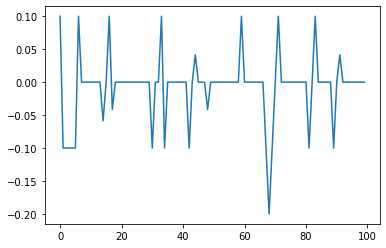

In [7]:
import matplotlib.pyplot as plt
# visualize the reward
plt.figure()
plt.plot(reward_hist)

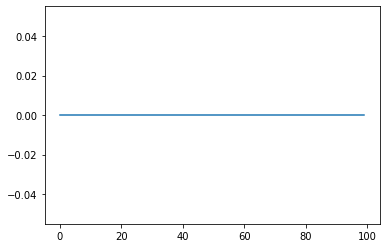

In [8]:
# visualize the done label
plt.figure()
plt.plot(done_hist)

In [24]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
def show_frame(idx):
    plt.imshow(((state_hist[idx]['rgb'][:,:,:3] * 255).astype(np.uint8)))

interactive_plot = interactive(show_frame, idx=(0,99))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=49, description='idx', max=99), Output(layout=Layout(height='350px'))), …

In [20]:
def show_frame(idx):
    plt.imshow(((state_hist[idx]['depth'])))

interactive_plot = interactive(show_frame, idx=(0,99))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=49, description='idx', max=99), Output(layout=Layout(height='350px'))), …

In [22]:
def show_lidar(idx):
    plt.plot(((state_hist[idx]['scan'])))

interactive_plot = interactive(show_lidar, idx=(0,99))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=49, description='idx', max=99), Output(layout=Layout(height='350px'))), …